In [0]:
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
from PIL import Image
import numpy as np
import tensorflow as tf


RESHAPE = (152, 152)

def is_an_image_file(filename):
    IMAGE_EXTENSIONS = ['.png', '.jpg', '.jpeg']
    for ext in IMAGE_EXTENSIONS:
        if ext in filename:
            return True
    return False


def list_image_files(directory):
    files = sorted(os.listdir(directory))
    return [os.path.join(directory, f) for f in files if is_an_image_file(f)]


def load_image(path):
    img = Image.open(path)
    return img


def preprocess_image(cv_img):
    cv_img = cv_img.resize(RESHAPE)
    img = np.array(cv_img)
    img = (img - 127.5) / 127.5
    return img


def deprocess_image(img):
    img = img * 127.5 + 127.5
    return img.astype('uint8')


def save_image(np_arr, path):
    img = np_arr * 127.5 + 127.5
    im = Image.fromarray(img)
    im.save(path)


def load_images(path, n_images):
    if n_images < 0:
        n_images = float("inf")
    A_paths, B_paths = os.path.join(path, 'A'), os.path.join(path, 'B')
    all_A_paths, all_B_paths = list_image_files(A_paths), list_image_files(B_paths)
    images_A, images_B = [], []
    images_A_paths, images_B_paths = [], []
    for path_A, path_B in zip(all_A_paths, all_B_paths):
        img_A, img_B = load_image(path_A), load_image(path_B)
        images_A.append(preprocess_image(img_A))
        images_B.append(preprocess_image(img_B))
        images_A_paths.append(path_A)
        images_B_paths.append(path_B)
        if len(images_A) > n_images - 1: break

    return {
        'A': np.array(images_A),
        'A_paths': np.array(images_A_paths),
        'B': np.array(images_B),
        'B_paths': np.array(images_B_paths)
    }

def write_log(callback, names, logs, batch_no):
    """
    Util to write callback for Keras training
    """
    for name, value in zip(names, logs):
        summary = tf.Summary()
        summary_value = summary.value.add()
        summary_value.simple_value = value
        summary_value.tag = name
        callback.writer.add_summary(summary, batch_no)
        callback.writer.flush()

In [0]:
n_images = 32
data = load_images('drive/My Drive/GoproAB/train', n_images)

In [0]:
y_train, x_train = data['B'], data['A']

In [0]:
from matplotlib import pyplot as plt

In [0]:
from keras.layers import Input, Conv2D, Activation, BatchNormalization
from keras.layers.merge import Add
from keras.layers.core import Dropout

def res_block(input, filters, kernel_size=(3,3), strides=(1,1), use_dropout=False):
    """
    Instanciate a Keras Resnet Block using sequential API.
    :param input: Input tensor
    :param filters: Number of filters to use
    :param kernel_size: Shape of the kernel for the convolution
    :param strides: Shape of the strides for the convolution
    :param use_dropout: Boolean value to determine the use of dropout
    :return: Keras Model
    """
    x = ReflectionPadding2D((1,1))(input)
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=strides,)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    if use_dropout:
        x = Dropout(0.5)(x)

    x = ReflectionPadding2D((1,1))(x)
    x = Conv2D(filters=filters,
                kernel_size=kernel_size,
                strides=strides,)(x)
    x = BatchNormalization()(x)

    # Two convolution layers followed by a direct connection between input and output
    merged = Add()([input, x])
    return merged

Using TensorFlow backend.


In [0]:
from keras.layers import Input, Activation, Add
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.core import Lambda
from keras.layers.normalization import BatchNormalization
from keras.models import Model

#from layer_utils import ReflectionPadding2D, res_block

ngf = 64
input_nc = 3
output_nc = 3
input_shape_generator = (256, 256, input_nc)
n_blocks_gen = 9


def generator_model():
    """Build generator architecture."""
    # Current version : ResNet block
    inputs = Input(shape=image_shape)

    x = ReflectionPadding2D((3, 3))(inputs)
    x = Conv2D(filters=ngf, kernel_size=(7,7), padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Increase filter number
    n_downsampling = 2
    for i in range(n_downsampling):
        mult = 2**i
        x = Conv2D(filters=ngf*mult*2, kernel_size=(3,3), strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    # Apply 9 ResNet blocks
    mult = 2**n_downsampling
    for i in range(n_blocks_gen):
        x = res_block(x, ngf*mult, use_dropout=True)

    # Decrease filter number to 3 (RGB)
    for i in range(n_downsampling):
        mult = 2**(n_downsampling - i)
        x = Conv2DTranspose(filters=int(ngf * mult / 2), kernel_size=(3,3), strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    x = ReflectionPadding2D((3,3))(x)
    x = Conv2D(filters=output_nc, kernel_size=(7,7), padding='valid')(x)
    x = Activation('tanh')(x)

    # Add direct connection from input to output and recenter to [-1, 1]
    outputs = Add()([x, inputs])
    outputs = Lambda(lambda z: z/2)(outputs)

    model = Model(inputs=inputs, outputs=outputs, name='Generator')
    return model

In [0]:
from keras.layers import Input
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D
from keras.layers.core import Dense, Flatten
from keras.layers.normalization import BatchNormalization
from keras.models import Model

ndf = 64
output_nc = 3
input_shape_discriminator = (152, 152, output_nc)


def discriminator_model():
    """Build discriminator architecture."""
    n_layers, use_sigmoid = 3, False
    inputs = Input(shape=input_shape_discriminator)

    x = Conv2D(filters=ndf, kernel_size=(4,4), strides=2, padding='same')(inputs)
    x = LeakyReLU(0.2)(x)

    nf_mult, nf_mult_prev = 1, 1
    for n in range(n_layers):
        nf_mult_prev, nf_mult = nf_mult, min(2**n, 8)
        x = Conv2D(filters=ndf*nf_mult, kernel_size=(4,4), strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

    nf_mult_prev, nf_mult = nf_mult, min(2**n_layers, 8)
    x = Conv2D(filters=ndf*nf_mult, kernel_size=(4,4), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(filters=1, kernel_size=(4,4), strides=1, padding='same')(x)
    if use_sigmoid:
        x = Activation('sigmoid')(x)

    x = Flatten()(x)
    x = Dense(1024, activation='tanh')(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=x, name='Discriminator')
    return model

In [0]:
from keras.layers import Input
from keras.models import Model

def generator_containing_discriminator_multiple_outputs(generator, discriminator):
    inputs = Input(shape=image_shape)
    generated_images = generator(inputs)
    outputs = discriminator(generated_images)
    model = Model(inputs=inputs, outputs=[generated_images, outputs])
    return model

In [0]:
import keras.backend as K
from keras.applications.vgg16 import VGG16
from keras.models import Model

image_shape = (152, 152, 3)

def perceptual_loss(y_true, y_pred):
    vgg = VGG16(include_top=False, weights='imagenet', input_shape=image_shape)
    loss_model = Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)
    loss_model.trainable = False
    return K.mean(K.square(loss_model(y_true) - loss_model(y_pred)))
  
import keras.backend as K

def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true*y_pred)

In [0]:
from keras.engine.topology import Layer
from keras.utils import conv_utils

class ReflectionPadding2D(Layer):
    """Reflection-padding layer for 2D input (e.g. picture).
    This layer can add rows and columns or zeros
    at the top, bottom, left and right side of an image tensor.
    # Arguments
        padding: int, or tuple of 2 ints, or tuple of 2 tuples of 2 ints.
            - If int: the same symmetric padding
                is applied to width and height.
            - If tuple of 2 ints:
                interpreted as two different
                symmetric padding values for height and width:
                `(symmetric_height_pad, symmetric_width_pad)`.
            - If tuple of 2 tuples of 2 ints:
                interpreted as
                `((top_pad, bottom_pad), (left_pad, right_pad))`
        data_format: A string,
            one of `channels_last` (default) or `channels_first`.
            The ordering of the dimensions in the inputs.
            `channels_last` corresponds to inputs with shape
            `(batch, height, width, channels)` while `channels_first`
            corresponds to inputs with shape
            `(batch, channels, height, width)`.
            It defaults to the `image_data_format` value found in your
            Keras config file at `~/.keras/keras.json`.
            If you never set it, then it will be "channels_last".
    # Input shape
        4D tensor with shape:
        - If `data_format` is `"channels_last"`:
            `(batch, rows, cols, channels)`
        - If `data_format` is `"channels_first"`:
            `(batch, channels, rows, cols)`
    # Output shape
        4D tensor with shape:
        - If `data_format` is `"channels_last"`:
            `(batch, padded_rows, padded_cols, channels)`
        - If `data_format` is `"channels_first"`:
            `(batch, channels, padded_rows, padded_cols)`
    """

    def __init__(self,
                 padding=(1, 1),
                 data_format=None,
                 **kwargs):
        super(ReflectionPadding2D, self).__init__(**kwargs)
        self.data_format = normalize_data_format(data_format)
        if isinstance(padding, int):
            self.padding = ((padding, padding), (padding, padding))
        elif hasattr(padding, '__len__'):
            if len(padding) != 2:
                raise ValueError('`padding` should have two elements. '
                                 'Found: ' + str(padding))
            height_padding = conv_utils.normalize_tuple(padding[0], 2,
                                                        '1st entry of padding')
            width_padding = conv_utils.normalize_tuple(padding[1], 2,
                                                       '2nd entry of padding')
            self.padding = (height_padding, width_padding)
        else:
            raise ValueError('`padding` should be either an int, '
                             'a tuple of 2 ints '
                             '(symmetric_height_pad, symmetric_width_pad), '
                             'or a tuple of 2 tuples of 2 ints '
                             '((top_pad, bottom_pad), (left_pad, right_pad)). '
                             'Found: ' + str(padding))
        self.input_spec = InputSpec(ndim=4)

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_first':
            if input_shape[2] is not None:
                rows = input_shape[2] + self.padding[0][0] + self.padding[0][1]
            else:
                rows = None
            if input_shape[3] is not None:
                cols = input_shape[3] + self.padding[1][0] + self.padding[1][1]
            else:
                cols = None
            return (input_shape[0],
                    input_shape[1],
                    rows,
                    cols)
        elif self.data_format == 'channels_last':
            if input_shape[1] is not None:
                rows = input_shape[1] + self.padding[0][0] + self.padding[0][1]
            else:
                rows = None
            if input_shape[2] is not None:
                cols = input_shape[2] + self.padding[1][0] + self.padding[1][1]
            else:
                cols = None
            return (input_shape[0],
                    rows,
                    cols,
                    input_shape[3])

    def call(self, inputs):
        return spatial_reflection_2d_padding(inputs,
                                             padding=self.padding,
                                             data_format=self.data_format)

In [0]:
from tensorflow.python.keras import backend

def normalize_data_format(value):
  if value is None:
    value = backend.image_data_format()
  data_format = value.lower()
  if data_format not in {'channels_first', 'channels_last'}:
    raise ValueError('The `data_format` argument must be one of '
                     '"channels_first", "channels_last". Received: ' +
                     str(value))
  return data_format

In [0]:
from keras.engine import InputSpec
from keras.optimizers import Adam

def spatial_reflection_2d_padding(x, padding=((1, 1), (1, 1)), data_format=None):
    """
    Pad the 2nd and 3rd dimensions of a 4D tensor.
    :param x: Input tensor
    :param padding: Shape of padding to use
    :param data_format: Tensorflow vs Theano convention ('channels_last', 'channels_first')
    :return: Tensorflow tensor
    """
    assert len(padding) == 2
    assert len(padding[0]) == 2
    assert len(padding[1]) == 2
    if data_format is None:
        data_format = image_data_format()
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('Unknown data_format ' + str(data_format))

    if data_format == 'channels_first':
        pattern = [[0, 0],
                   [0, 0],
                   list(padding[0]),
                   list(padding[1])]
    else:
        pattern = [[0, 0],
                   list(padding[0]), list(padding[1]),
                   [0, 0]]
    return tf.pad(x, pattern, "REFLECT")

In [0]:
# Initialize models
g = generator_model()
d = discriminator_model()
d_on_g = generator_containing_discriminator_multiple_outputs(g, d)

# Initialize optimizers
g_opt = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
d_opt = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
d_on_g_opt = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

# Compile models
d.trainable = True
d.compile(optimizer=d_opt, loss=wasserstein_loss)
d.trainable = False
loss = [perceptual_loss, wasserstein_loss]
loss_weights = [100, 1]
d_on_g.compile(optimizer=d_on_g_opt, loss=loss, loss_weights=loss_weights)
d.trainable = True

58892288/58889256 [==============================] - 2s 0us/step


In [0]:
g.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 152, 152, 3)  0                                            
__________________________________________________________________________________________________
reflection_padding2d_1 (Reflect (None, 158, 158, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 152, 152, 64) 9472        reflection_padding2d_1[0][0]     
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 152, 152, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

In [0]:
d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 152, 152, 3)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 76, 76, 64)        3136      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 76, 76, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 38, 38, 64)        65600     
_________________________________________________________________
batch_normalization_24 (Batc (None, 38, 38, 64)        256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 19, 19, 128)       131200    
__________

In [0]:
d_on_g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 152, 152, 3)       0         
_________________________________________________________________
Generator (Model)            (None, 152, 152, 3)       11399171  
_________________________________________________________________
Discriminator (Model)        (None, 1)                 2938626   
Total params: 11,401,091
Trainable params: 11,388,675
Non-trainable params: 12,416
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [0]:
epoch_num = 50
batches = 8
batch_size = 32
critic_updates = 10
output_true_batch, output_false_batch = np.ones((batch_size, 1)), -np.ones((batch_size, 1))

In [0]:
for epoch in range(epoch_num):
  print('epoch: {}/{}'.format(epoch, epoch_num))
  print('batches: {}'.format(x_train.shape[0] / batch_size))

  # Randomize images into batches
  permutated_indexes = np.random.permutation(x_train.shape[0])

  for index in range(int(x_train.shape[0] / batch_size)):
      batch_indexes = permutated_indexes[index*batch_size:(index+1)*batch_size]
      image_blur_batch = x_train[batch_indexes]
      image_full_batch = y_train[batch_indexes]

epoch: 0/50
batches: 1.0
epoch: 1/50
batches: 1.0
epoch: 2/50
batches: 1.0
epoch: 3/50
batches: 1.0
epoch: 4/50
batches: 1.0
epoch: 5/50
batches: 1.0
epoch: 6/50
batches: 1.0
epoch: 7/50
batches: 1.0
epoch: 8/50
batches: 1.0
epoch: 9/50
batches: 1.0
epoch: 10/50
batches: 1.0
epoch: 11/50
batches: 1.0
epoch: 12/50
batches: 1.0
epoch: 13/50
batches: 1.0
epoch: 14/50
batches: 1.0
epoch: 15/50
batches: 1.0
epoch: 16/50
batches: 1.0
epoch: 17/50
batches: 1.0
epoch: 18/50
batches: 1.0
epoch: 19/50
batches: 1.0
epoch: 20/50
batches: 1.0
epoch: 21/50
batches: 1.0
epoch: 22/50
batches: 1.0
epoch: 23/50
batches: 1.0
epoch: 24/50
batches: 1.0
epoch: 25/50
batches: 1.0
epoch: 26/50
batches: 1.0
epoch: 27/50
batches: 1.0
epoch: 28/50
batches: 1.0
epoch: 29/50
batches: 1.0
epoch: 30/50
batches: 1.0
epoch: 31/50
batches: 1.0
epoch: 32/50
batches: 1.0
epoch: 33/50
batches: 1.0
epoch: 34/50
batches: 1.0
epoch: 35/50
batches: 1.0
epoch: 36/50
batches: 1.0
epoch: 37/50
batches: 1.0
epoch: 38/50
batches: 

In [0]:
from IPython.display import clear_output

In [0]:
for epoch in range(epoch_num):
  
  for index in range(batches):
    clear_output()
    print("at ",epoch+1,"/",epoch_num,"epoch")
    print("at index ",index+1)
    # [Batch Preparation]

    # Generate fake inputs
    generated_images = g.predict(x=image_blur_batch, batch_size=batch_size)
    
    # Train multiple times discriminator on real and fake inputs
    for _ in range(critic_updates):
        d_loss_real = d.train_on_batch(image_full_batch, output_true_batch)
        d_loss_fake = d.train_on_batch(generated_images, output_false_batch)
        d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)
    print("wasserstein loss on train discriminator ",d_loss)

    d.trainable = False
    # Train generator only on discriminator's decision and generated images
    d_on_g_loss = d_on_g.train_on_batch(image_blur_batch, [image_full_batch, output_true_batch])
    print("perceptual loss on train generator",d_on_g_loss[0])
    print("wasserstein loss on train generator",d_on_g_loss[1])

    d.trainable = True
    

at  50 / 50 epoch
at index  8
wasserstein loss on train discriminator  -0.49999991059303284
perceptual loss on train generator 795.12885
wasserstein loss on train generator 7.9412885


<function matplotlib.pyplot.show>

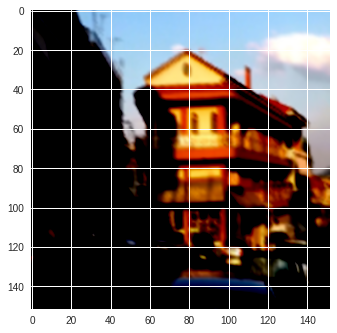

In [0]:
plt.imshow(x_train[0], interpolation = 'bicubic')
plt.show

<function matplotlib.pyplot.show>

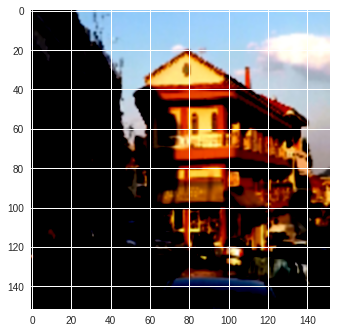

In [0]:
plt.imshow(y_train[0], interpolation = 'bicubic')
plt.show

<function matplotlib.pyplot.show>

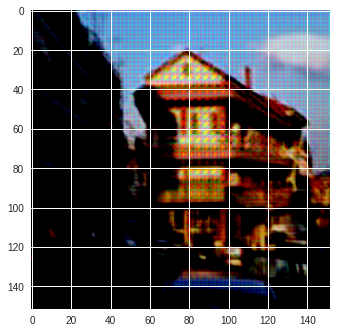

In [0]:
db = g.predict(x_train)
plt.imshow(db[0], interpolation = 'bicubic')
plt.show